#### Notebook options

In [2]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [3]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

#### Imports

In [5]:
# import bokeh
# import time
# import copy
# import scipy.stats as ss

# from coffea import hist, processor, nanoevents, util
# from coffea.nanoevents.methods import candidate
# from coffea.nanoevents import NanoAODSchema, BaseSchema

# import awkward as ak
# import numpy as np
# import glob as glob
# import itertools
# import pandas as pd
# from numpy.random import RandomState

# from dask.distributed import Client
# import inspect
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from pltStyle import pltStyle
# import os
# # %matplotlib notebook 
# # %matplotlib notebook 

In [6]:
# import sys
# sys.path.insert(0,'/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/')
# sys.path

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl

In [8]:
from plotters.pltStyle import pltStyle
pltStyle(style='hep')
# plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [9]:
# tag = '_L5'                 ### L5 or L23, but L23 not supported since ages

# ### name of the specific run:
# # add_tag = '_LHEflav1_TTBAR-Summer16-cFlip' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
# # add_tag='_fine_etaBins'+add_tag
# add_tag = '_QCD-MG-Her'
# # add_tag = '_Herwig-QCD-etaAut18'

# tag_full = tag+add_tag

In [10]:
from helpers import read_data
# def read_data(name, samp):
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+'_'+samp+tag_full+'.csv').set_index('etaBins')
#     data = df_csv.to_numpy().transpose()
#     return data

# def read_data2(name, samp, tag_full):
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+'_'+samp+tag_full+'.csv').set_index('etaBins')
#     data = df_csv.to_numpy().transpose()
#     return data

### Fitting the inverse median responses

In [11]:
tag_full = '_L5_QCD-MG-Her'
df = pd.read_csv('out_txt/EtaBinsvsPtBins'+"Median"+"_b"+tag_full+'.csv').set_index('etaBins')

In [12]:
etabins = np.append(df.index.to_numpy(), 5.191)
ptbins = np.append(df.columns.to_numpy(float), 10000)
ptbins_c = (ptbins[:-1]+ptbins[1:])/2

In [13]:
def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

In [14]:
def response_fnc_raw(x, p0, p1, p2, p3, p4, p5):
    response_fnc(x, *[p0, p1, p2, p3, p4, p5])

In [15]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    logx = np.log10(x)
    return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))

def two_gaus_fnc(x, *p):
    p0, p1, p2, p3, p4, p5, p6, p7, p8 = p
    return (  p0
            + (p1/((np.log10(x)**2)+p2))
            + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
            + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
           )
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [16]:
#### initial values borrowed from Winter14 data
#### https://github.com/cms-jet/JECDatabase/blob/master/textFiles/Winter14_V8_MC/Winter14_V8_MC_L5Flavor_AK5Calo.txt/
#### used for fit `response_fnc`
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'u':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    'all':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],  
    'ud':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'q':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    
}

## Initial values for the two gaussian fit
init_two_gaus = [3,0,1,2,0,1,2,3,4]

Better starting fit values I found

In [17]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

### Fitting the mean responses

In [18]:
my_mapping = {"all": "aJ",
              "b": "bT",
              "c": "cT",
              "s": "sT",
              "g": "gT",
              "u": "uT",
              "d": "dT",
              "ud": "udT",
              "q": "qT"}

In [25]:
def fit_corrections(samp, etabin, inlist, init_vals_Winter14=np.array([1,1,1,1,1,1]), plot_initial_val=False):
    print('Fitting subsample: ', samp, 'Eta bin = : ', etabin)

    mean, meanstd, reco_pt = inlist
#     meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
#     reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
    
    use_recopt=True

    ptmin_idx = np.searchsorted(ptbins_c, 20, side='left')-1
#     ptmax_idx = np.searchsorted(ptbins_c, 1700, side='right')
    ptmax_idx = len(reco_pt)
    mean_range = range(ptmin_idx, ptmax_idx)


#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
    means = mean[mean_range]
    ptbins2fit = reco_pt[mean_range] if use_recopt else ptbins_c[mean_range]
    validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))

    means2fit = means[validpt_mask]
    ptbins2fit = ptbins2fit[validpt_mask]
    meanstd = np.abs(meanstd[mean_range][validpt_mask])

    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
#     meanstd = np.sqrt(meanvar2fit)
    where_limit_std = (meanstd/means2fit)<min_rel_uncert
    meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

    fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
    fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])
    print(f'fit_min_lim, {fit_min_lim}, fit_max_lim, {fit_max_lim}, mean_range {mean_range}, validpt_mask, {validpt_mask}')

    xplot = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+5,1000) #-200 to plot the fitted curved outside of the points

    print("init_vals_Winter14", init_vals_Winter14)
    try:
        p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_Winter14) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=meanstd)
    except(RuntimeError):
        print("Winter 14 fit failed")
        p_resp, p_resp_err = [[np.nan]*6]*2
    #      = np.nan*6
    try:
        p_resp2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=init_two_gaus) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=p_resp2, sigma=meanstd)
    except(RuntimeError):
        print("Two fits failed")
        p_resp2, p_resp_err2 = [[np.nan]*9]*2
    #      = np.nan*6


    # p_resp_err
    p_poly4_1, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
    p_poly4, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=p_poly4_1, sigma=meanstd)

    fit_res_new = np.concatenate([[etabins[etabin], etabins[etabin+1],
                               len(p_poly4), 
                               fit_min_lim, fit_max_lim],
                              p_poly4 ])

    
    yvals_resp = response_fnc(xplot, *p_resp)
    yvals_resp_err = response_fnc(xplot, *p_resp_err)
    y_poly4 = poly4(xplot, *p_poly4)

    chi2_poly4 = np.sum((poly4(ptbins2fit, *p_poly4) - means2fit)**2/meanstd**2)
    Ndof_poly4 = len(ptbins2fit) - 5

    chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanstd**2)
    Ndof_resp = len(ptbins2fit) - 6


    fig, ax = plt.subplots()

    plt.errorbar(ptbins2fit, means2fit, yerr=meanstd, marker='o',
                 linestyle="none", label=f'Data {etabins[etabin]}'+r'$<\eta<'+f'${etabins[etabin+1]}')

    eta_string = '_eta'+str(etabins[etabin])+'to'+str(etabins[etabin+1])
    eta_string = eta_string.replace('.','')
    if np.isnan(chi2_resp): 
        winter14_lab = 'Winter14 func, failed'
    else:
        winter14_lab= 'Original func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)
    
    ax.plot(xplot, yvals_resp_err, label=winter14_lab, linewidth=2.3, markersize=0);
    ax.plot(xplot, yvals_resp, label="Winer14, No uncertainty in fit", linewidth=1.5, markersize=0);
    ax.plot(xplot, y_poly4, label=r'Poly, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly4, Ndof_poly4),linewidth=2.7, markersize=0);
#     ax.plot(xplot, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.2);

    if plot_initial_val:
        yvals_init = response_fnc(xplot, *init_vals_Winter14)
        ax.plot(xplot, yvals_init, label="Initial values for Winter14", linewidth=1.8, markersize=0);
        
    
    
    std = meanstd
    norm_pos = (std<0.1) &  (std != np.inf)

    ax.set_xlabel(r'$p_{T,reco}$ (GeV)')
    ax.set_ylabel(r'correction (1/median)');
    ax.set_xscale('log')

    ax.set_xticks([])
    ax.set_xticks([20, 50, 100, 200, 500, 1000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    # ax.set_ylim([0.8,1.1])
    ax.legend(prop={'size': 7})
#         if not test_run:
#             plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#         else:
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
    # fig.set_size_inches(6, 4, forward=True)
    plt.show();
    plt.close();
    
    return fit_res_new

In [26]:
# [data, meanstd, recopt]
def fit_corrections_for_interact(samp, etabin, p0=1, p1=1, p2=1, p3=1, p4=1, p5=1, plot_initial_val=False):
    data = read_data("Median", samp)[:,etabin]
    data[data==0] = np.nan
    mean = (1/data) #*closure[:,etabin]
    meanstd = mean**2*read_data("MedianStd", samp)[:,etabin]
    reco_pt = read_data("MeanRecoPt", samp)[:,etabin]
    fit_corrections(samp, etabin, [data, meanstd, recopt], init_vals_Winter14=np.array([p0, p1, p2, p3, p4, p5]), plot_initial_val=plot_initial_val)

In [27]:
# import sympy 
# from sympy import chebyshevt
# min_rel_uncert = 0.001
# x = sympy.symbols('x')
# closure = read_data("Median", 'all')
# fit_corrections('b', 1)
# init_vals_Winter14

In [28]:
# samp = 'b'
# etabin=0
# mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
# meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2
# reco_pt = read_data("MeanRecoPt", samp)[:,etabin]

In [29]:
# flav = 'b'
# read_data("MedianStd", flav, tag_full)

Fitting subsample:  all Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 3000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False]
init_vals_Winter14 [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]
Winter 14 fit failed


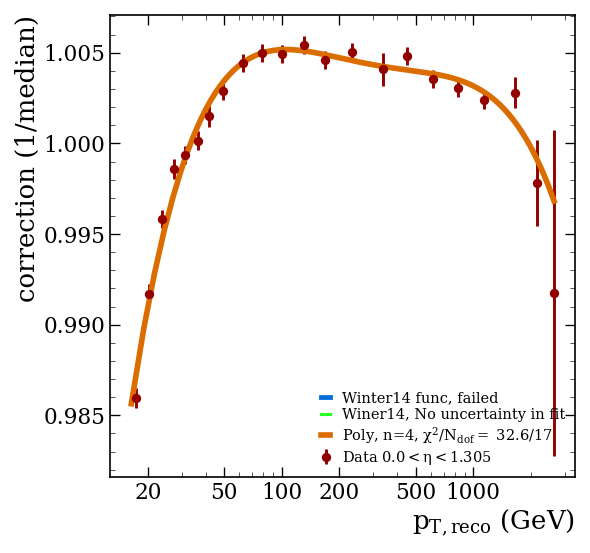

Fitting subsample:  all Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed
Two fits failed


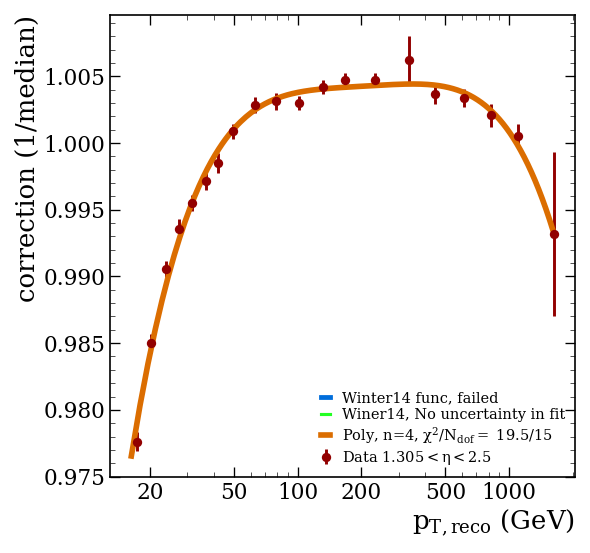

Fitting subsample:  all Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 750.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed


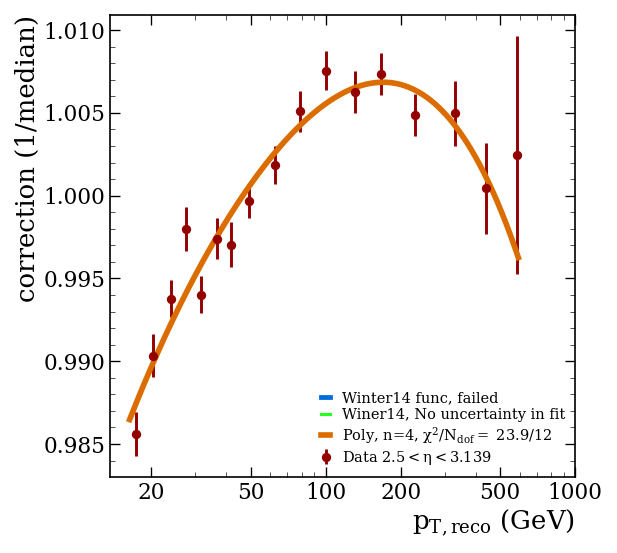

Fitting subsample:  all Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 400.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed
Two fits failed


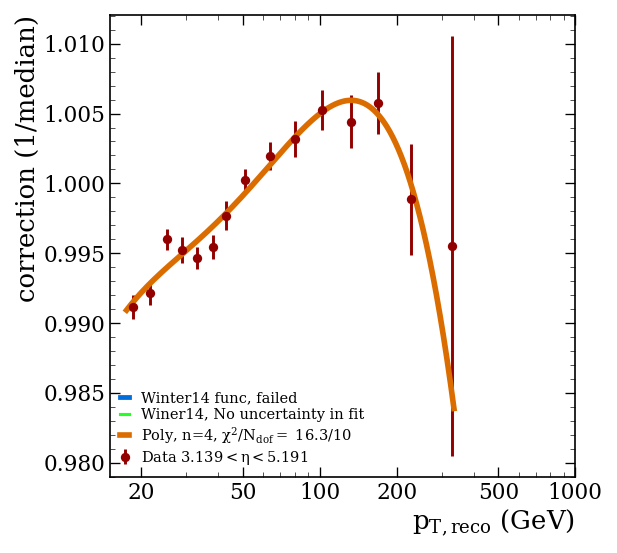

Fitting subsample:  b Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [0.981014871, -0.00646744813, -1.0565884, 5354.45486, 29.9200015, 121.399356]
Winter 14 fit failed
Two fits failed


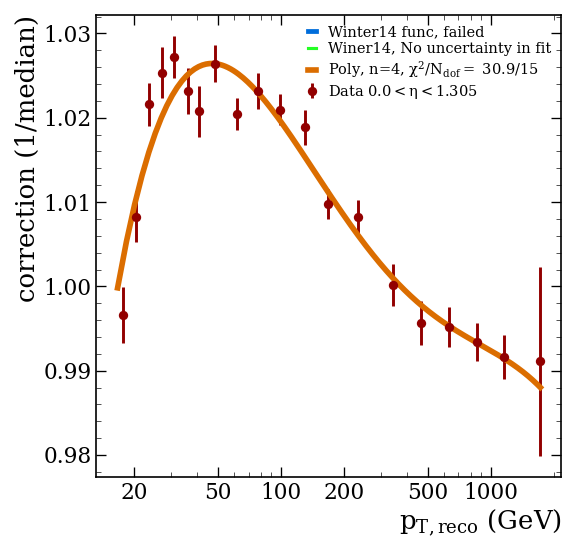

Fitting subsample:  b Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 1500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed
Two fits failed


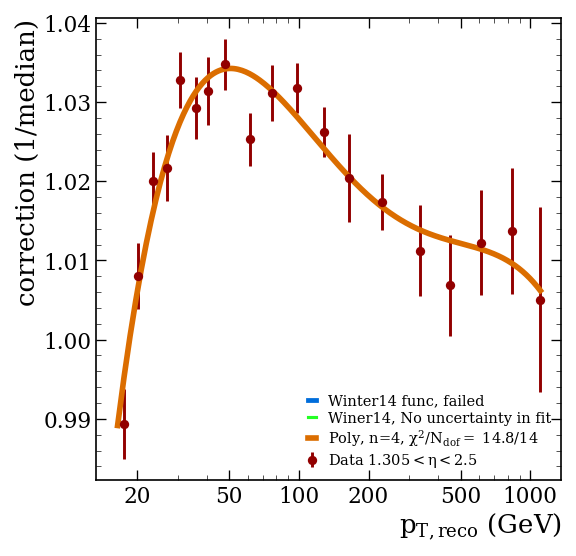

Fitting subsample:  b Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 300.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


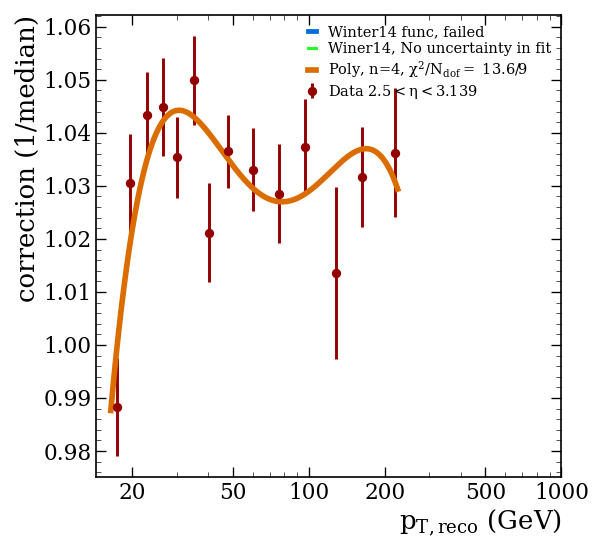

Fitting subsample:  b Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 200.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False]
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


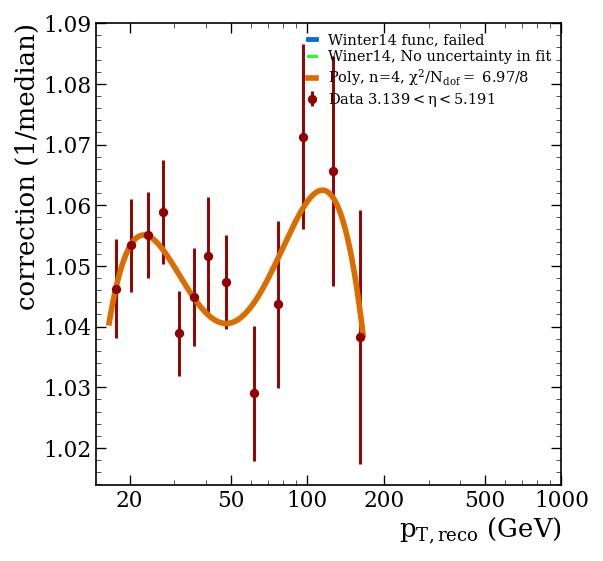

Fitting subsample:  c Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041]
Winter 14 fit failed
Two fits failed


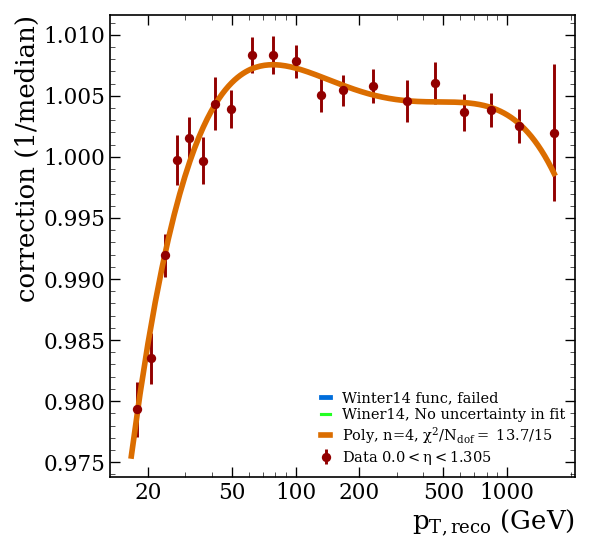

Fitting subsample:  c Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 1500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
init_vals_Winter14 [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


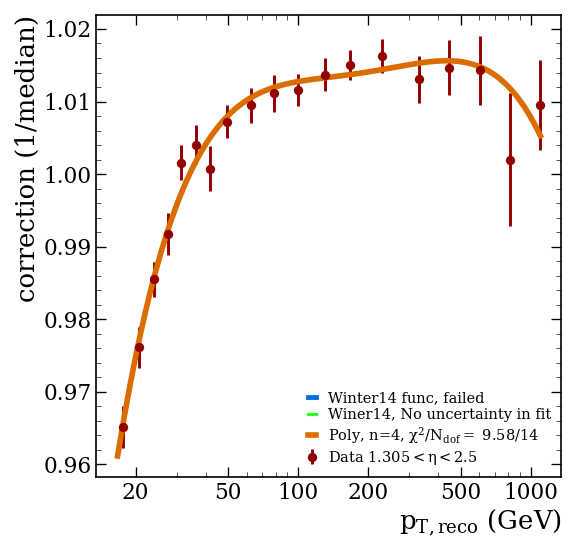

Fitting subsample:  c Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 400.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False]
init_vals_Winter14 [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749]
Winter 14 fit failed
Two fits failed


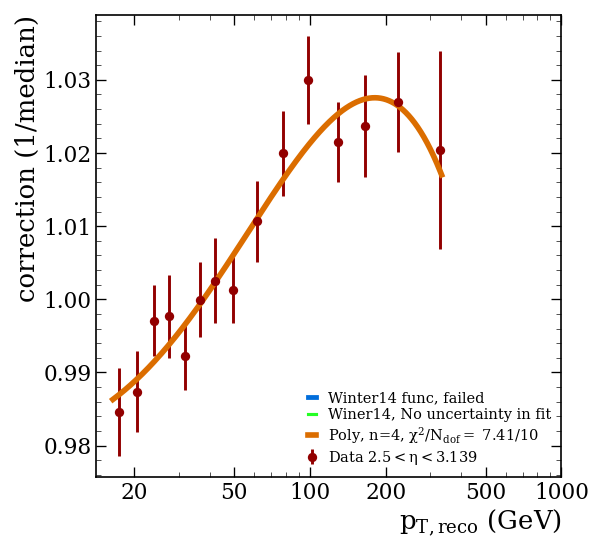

Fitting subsample:  c Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 200.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False]
init_vals_Winter14 [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749]
Winter 14 fit failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


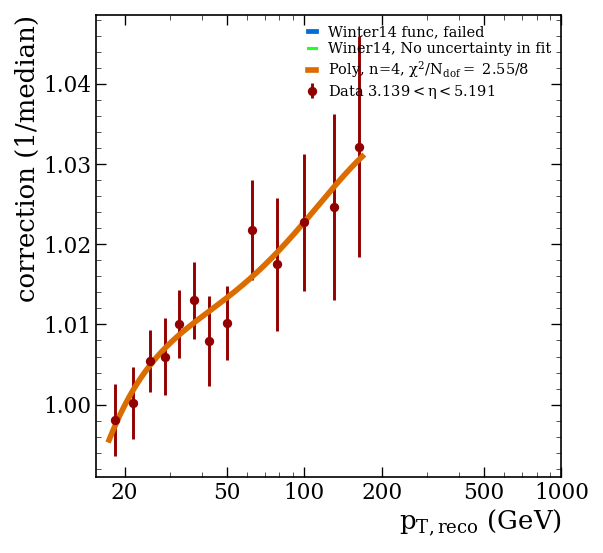

Fitting subsample:  u Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False]
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed


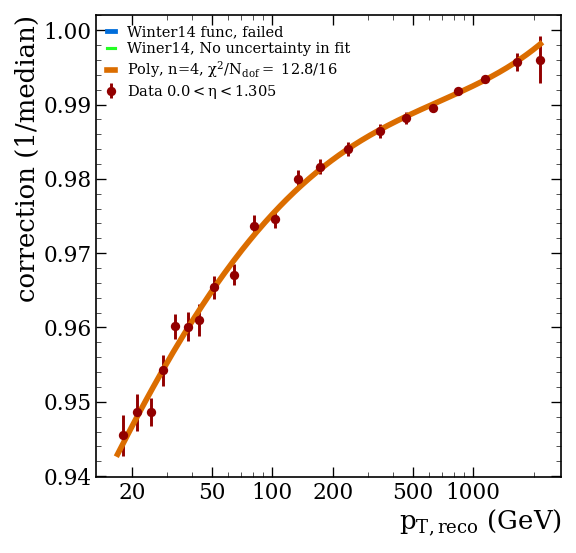

Fitting subsample:  u Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


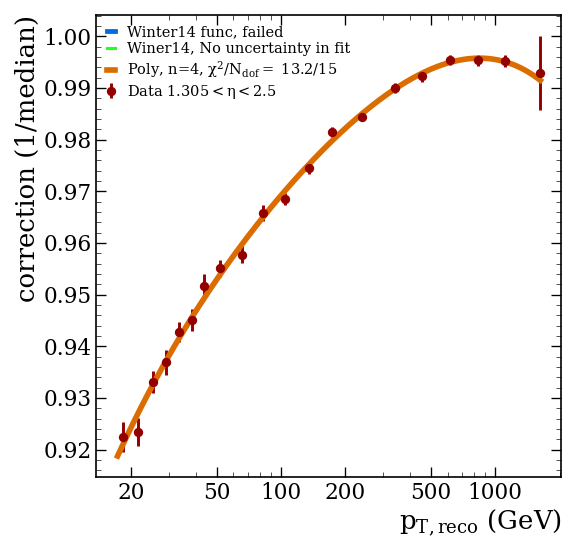

Fitting subsample:  u Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 750.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


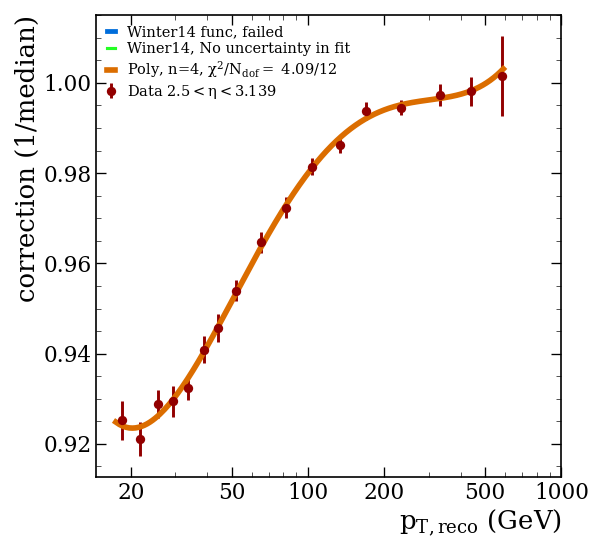

Fitting subsample:  u Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 400.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


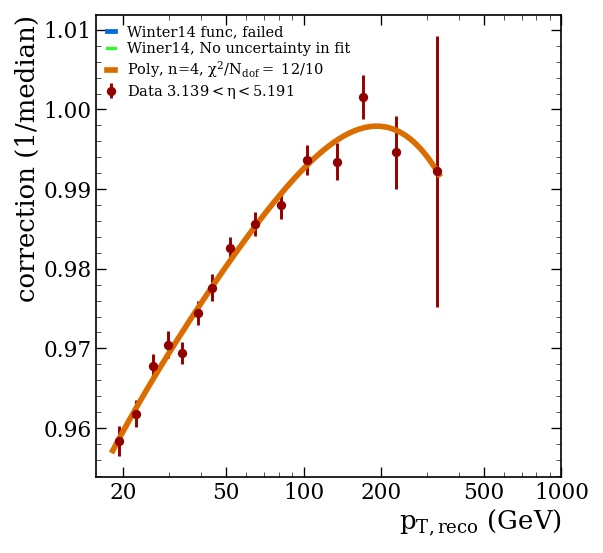

Fitting subsample:  d Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False]
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


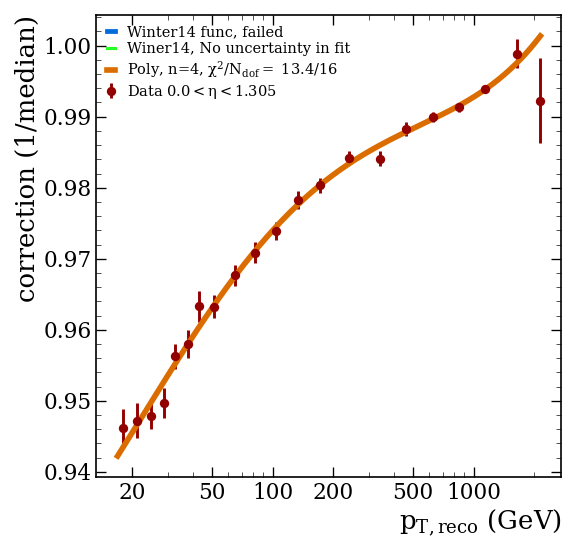

Fitting subsample:  d Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 1500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


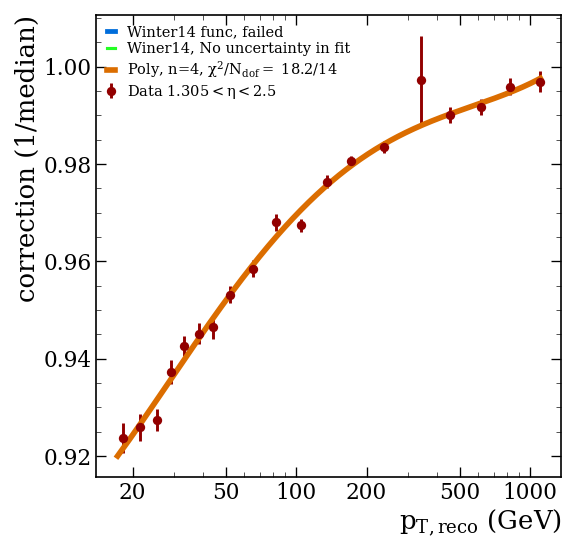

Fitting subsample:  d Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 750.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


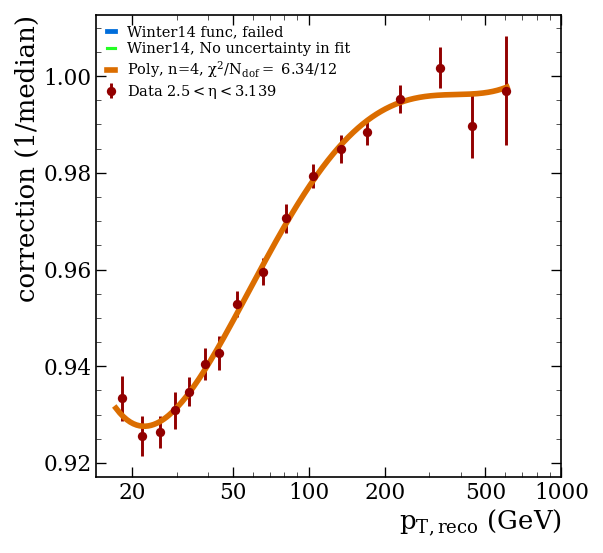

Fitting subsample:  d Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 300.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


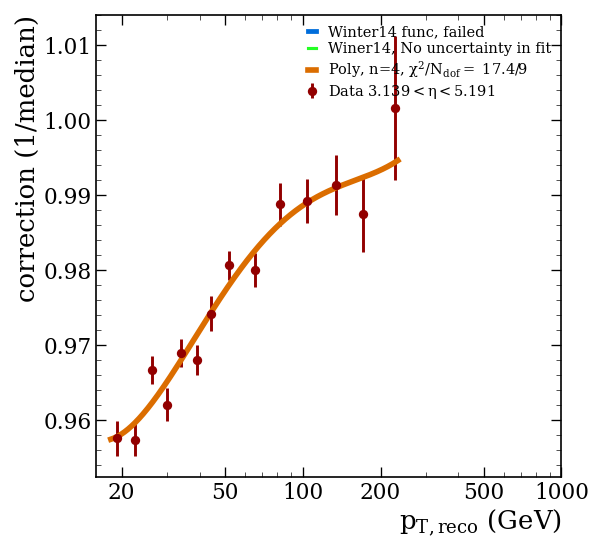

Fitting subsample:  g Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False False False
 False False False]
init_vals_Winter14 [0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485]
Winter 14 fit failed
Two fits failed


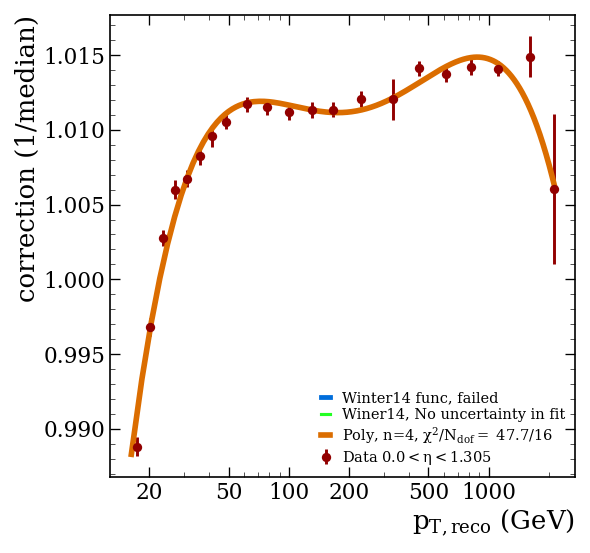

Fitting subsample:  g Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 1500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
init_vals_Winter14 [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263]
Winter 14 fit failed
Two fits failed


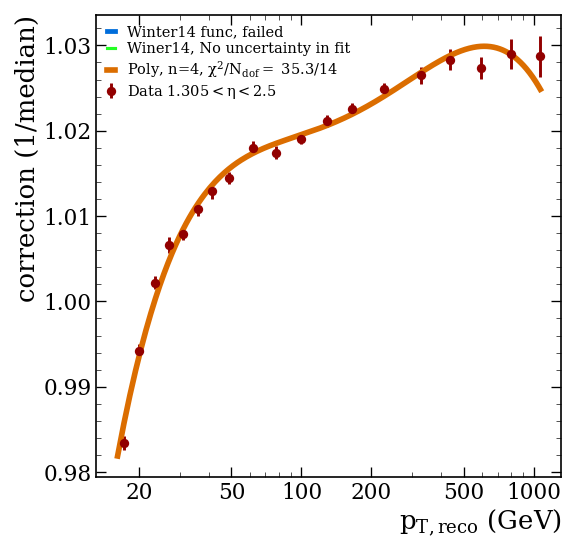

Fitting subsample:  g Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 550.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
 False False False]
init_vals_Winter14 [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263]
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


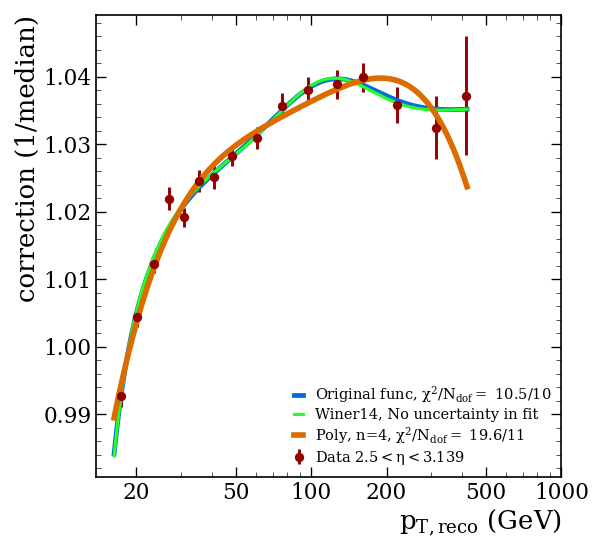

Fitting subsample:  g Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 300.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False]
init_vals_Winter14 [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


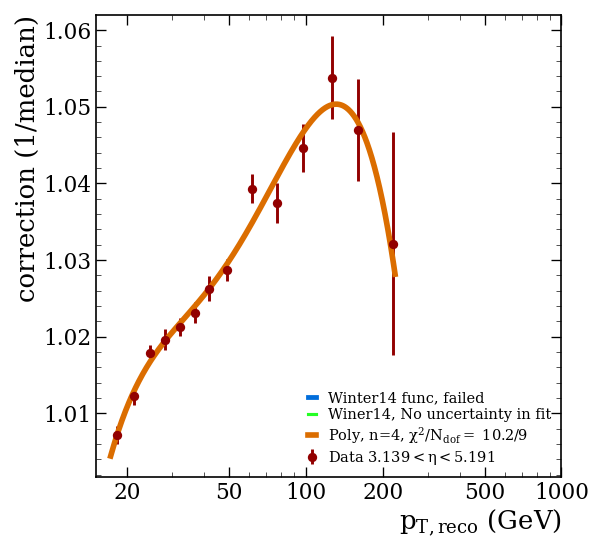

Fitting subsample:  s Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


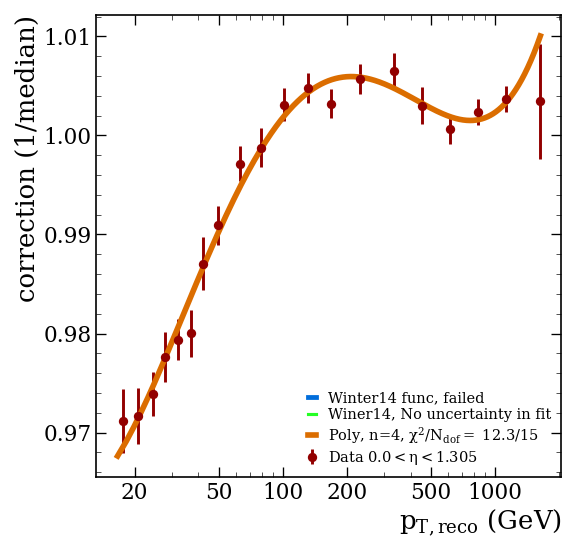

Fitting subsample:  s Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 1500.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


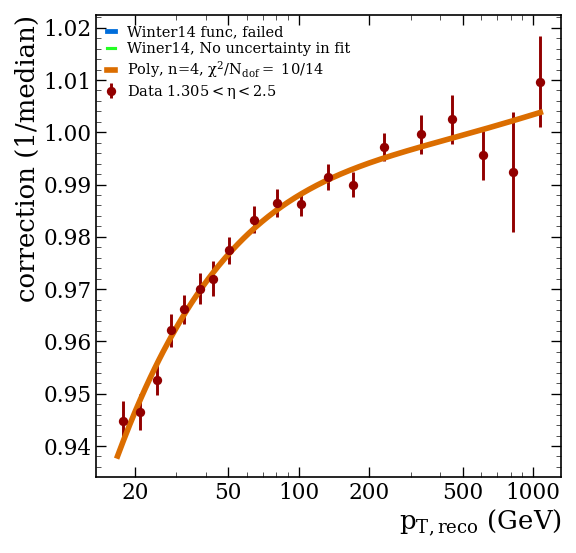

Fitting subsample:  s Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 300.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


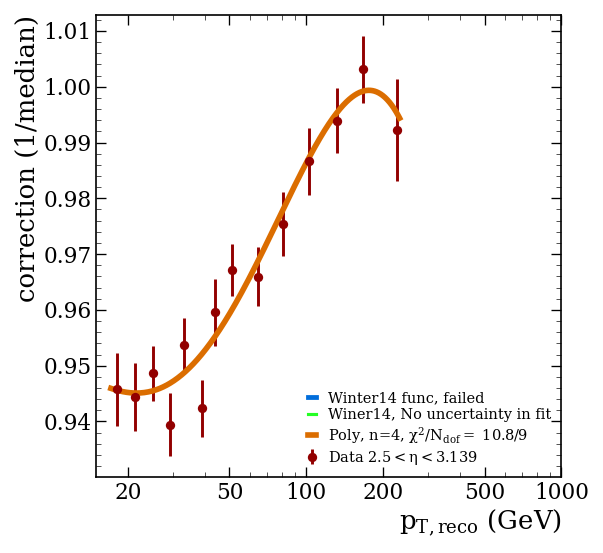

Fitting subsample:  s Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 200.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


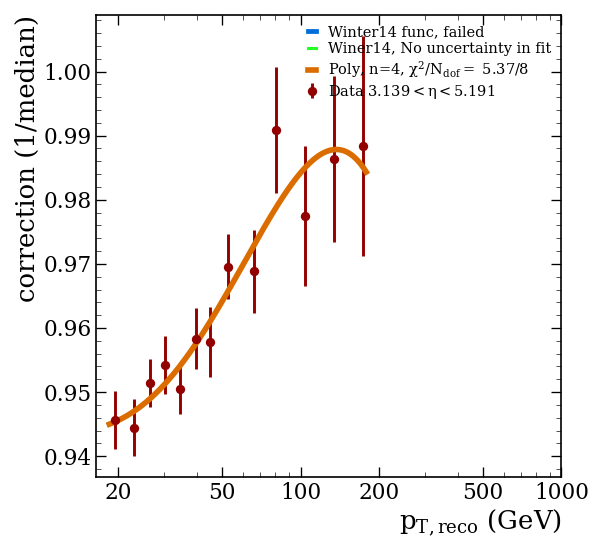

Fitting subsample:  ud Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 3000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False]
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


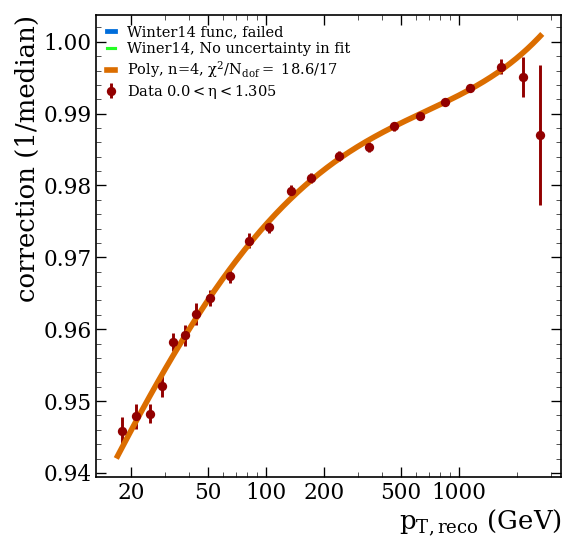

Fitting subsample:  ud Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


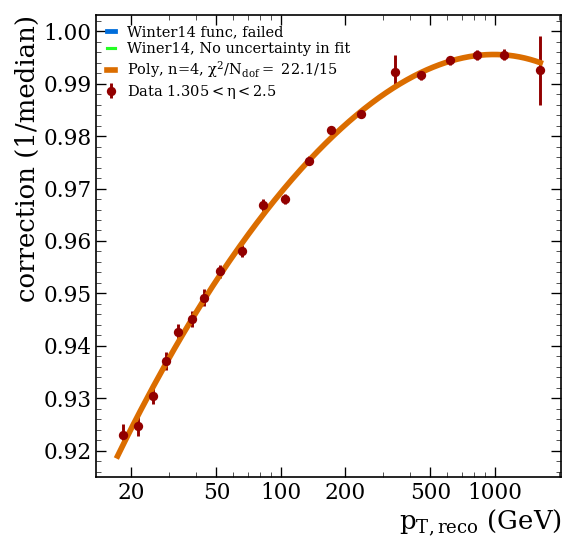

Fitting subsample:  ud Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 750.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


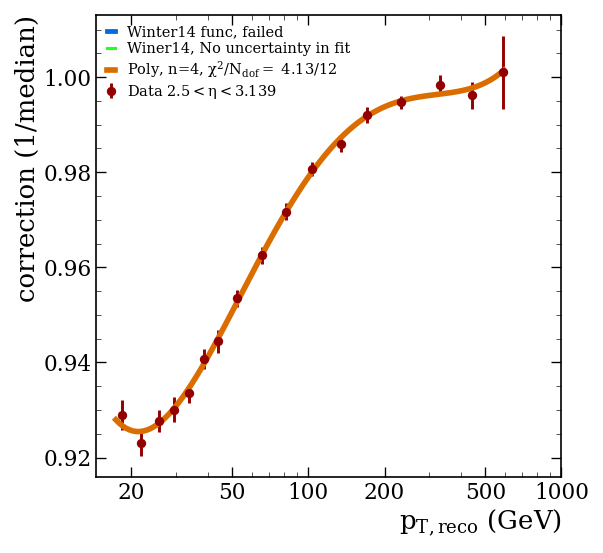

Fitting subsample:  ud Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 400.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_3662/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


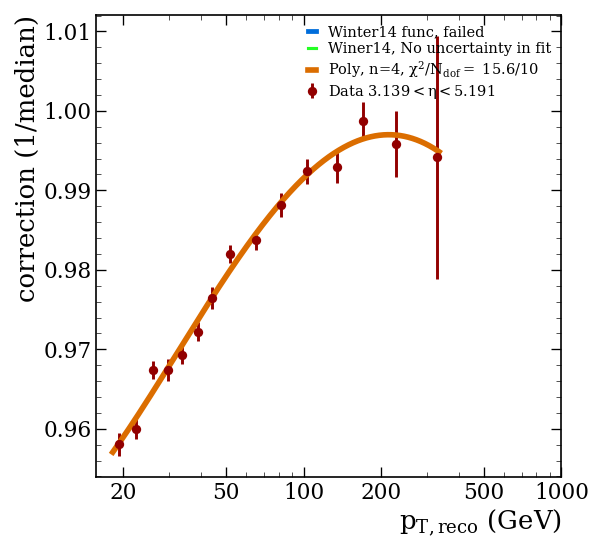

Fitting subsample:  q Eta bin = :  0
fit_min_lim, 17.0, fit_max_lim, 3000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False]
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


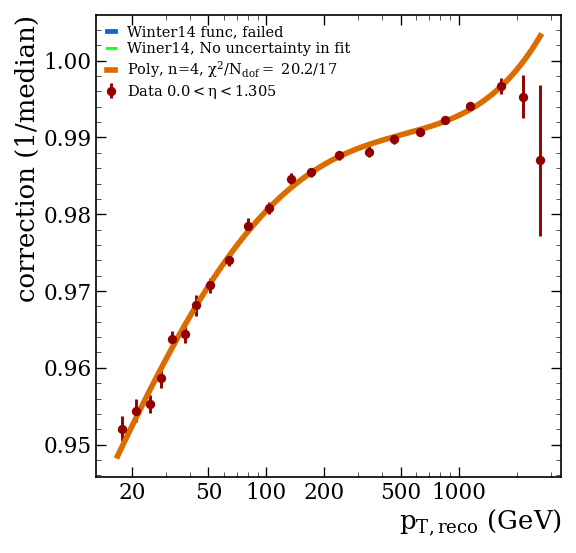

Fitting subsample:  q Eta bin = :  1
fit_min_lim, 17.0, fit_max_lim, 2000.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


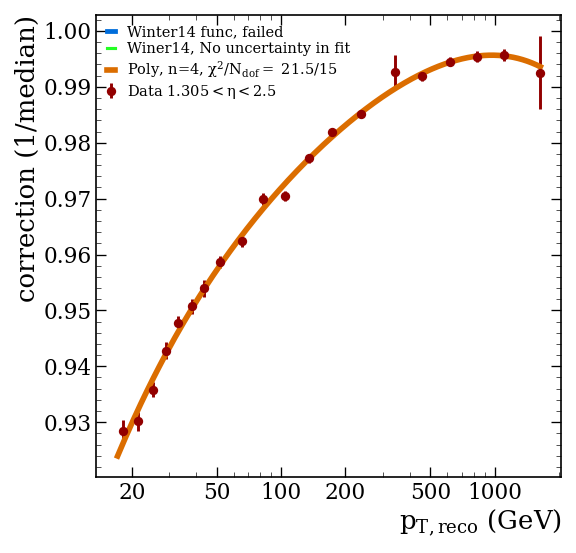

Fitting subsample:  q Eta bin = :  2
fit_min_lim, 17.0, fit_max_lim, 750.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


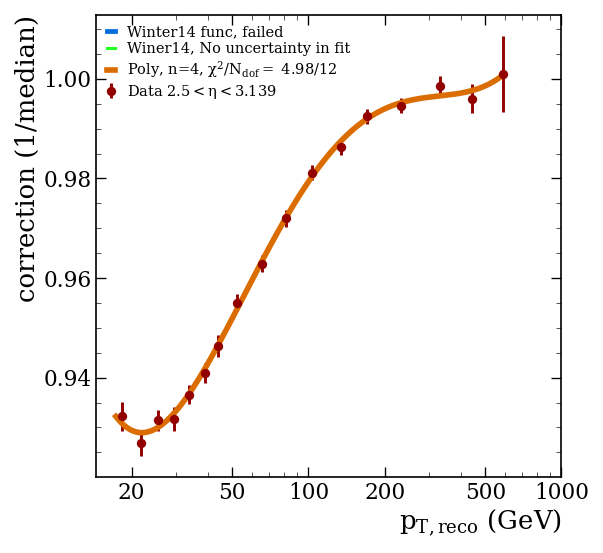

Fitting subsample:  q Eta bin = :  3
fit_min_lim, 17.0, fit_max_lim, 400.0, mean_range range(1, 28), validpt_mask, [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False]
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


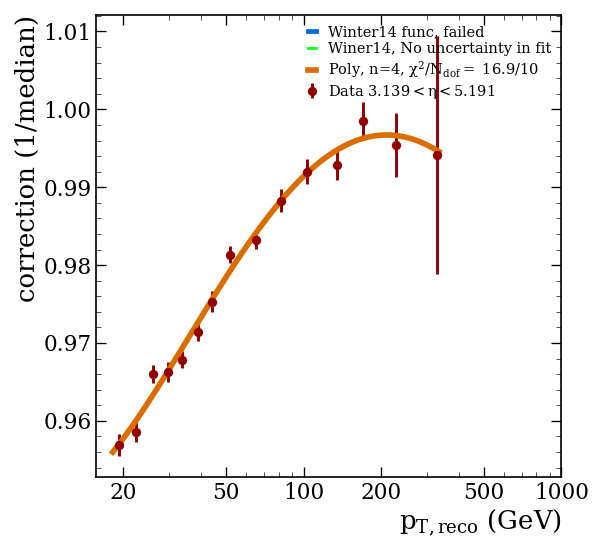

In [55]:
flavors = ['all', 'b', 'c', 'u', 'd', 'g', 's', 'ud', 'q']
# subsamples = ['all', 'b']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.0005
# tag_full = '_L5_TTBAR-JME'
tag_full = '_L5_QCD-MG-Her'
# tag_full = '_L5_QCD-MG-Py'

closure = read_data("Median", "all", '_L5_QCD-MG-Py')
# df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMedian_all_L5_QCD-JME-etaAut18'+'.csv').set_index('etaBins')
# closure = df_csv.to_numpy().transpose()
# closure = read_data("Median", 'all')
fit_res_all ={}
for flav in flavors:
    fit_res = []
    data = read_data("Median", flav, tag_full)
    data[data==0] = np.nan
    mean = (1/data)*closure #[:,etabin]
    meanstd = mean**2*read_data("MedianStd", flav, tag_full)
    reco_pt = read_data("MeanRecoPt", flav, tag_full)

    for etabin in range(len(etabins)-1):
        #if using Autumn18 binning, mapping to initial conditions
        meanfit = mean[:,etabin] #*closure[:,etabin]
        meanstdfit = meanstd[:,etabin]
        reco_ptfit = reco_pt[:,etabin]
        etabin_smalltolarge_dict = {0:0, 1:0, 1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2, 8:3, 9:3 }
        init_vals_Winter14 = init_vals_2014[flav][etabin_smalltolarge_dict[etabin]]
        fit_res_new = fit_corrections(flav, etabin, [meanfit, meanstdfit, reco_ptfit], init_vals_Winter14, plot_initial_val=False)
        fit_res = np.concatenate([fit_res, fit_res_new])
        
        
    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
    fit_res_all[my_mapping[flav]] = fit_res
'a';

In [56]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [udJ] (ud quark from diJet mixture) \n'+
'# [uJ] (u quark from diJet mixture) \n'+
'# [dJ] (d quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [57]:
# np.vstack([np.hstack([np.flip(fit_res_all['aJ'][:,0:2]*-1), np.flip(fit_res_all['aJ'][:,2:], 0)]), fit_res_all['aJ']])

In [54]:
with open("Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs_MG-Her.txt", 'w') as file:
    file.write(header_txt+'\n')
    for key in fit_res_all.keys():
        file.write('['+key.replace("T","J")+']\n')
#         file.write('['+key+']\n')
        file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*pow(log10(x),2)+[3]*pow(log10(x),3)+[4]*pow(log10(x),4)) Correction L5Flavor}\n')
        fit_res = fit_res_all[key]
        ### copy from the positive eta region into the negative
        fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
        for row in fit_res:
            row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
            line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
            file.write(line2write);

4; ## to suppress printouts of write

### Fit median responses in a specific bin interactivelly with ip widgets

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [20]:
# interact(response_fnc_raw, x=2, p0=10);

In [21]:
# all_subsamples = ['b', 'c', 'u', 'd', 'g', 's', 'all']

# import ipywidgets as widgets

# sub = widgets.Dropdown(
#     options=all_subsamples,
#     value='b',
#     description='Subsample:',
#     disabled=False,
# )

# etabin = widgets.Dropdown(
#     options=[0,1,2,3,4],
#     value=0,
#     description='Subsample:',
#     disabled=False,
# )

# print(init_vals_2014[sub.value][etabin.value])

# p0 = widgets.FloatSlider(value=7.5, min=0, max=10.0, step=0.1,
#                          description='p0', continuous_update=True, 
#                         )
# p1 = widgets.FloatSlider(value=13.8495, min=0, max=20.0, step=0.1, description='p2', continuous_update=True,
#                         )

# p2 = widgets.FloatSlider(
#     value=17.8549,
#     min=0,
#     max=20.0,
#     step=0.1,
#     description='p2',
#     continuous_update=True,
# )

# p3 = widgets.FloatSlider(
#     value=-0.215711,
#     min=-10.0,
#     max=10.0,
#     step=0.1,
#     description='p3',
#     continuous_update=True,
# )

# p4 = widgets.FloatSlider(
#     value=0.576285,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p4',
#     continuous_update=True,
# )

# p5 = widgets.FloatSlider(
#     value=1.42258,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p5',
#     continuous_update=True,
# )



# display(sub, etabin, p0, p1, p2, p3, p4, p5)

# # [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]

In [22]:
# a = widgets.IntSlider(description="Delayed", continuous_update=False)
# b = widgets.IntText(description="Delayed", continuous_update=False)
# c = widgets.IntSlider(description="Continuous", continuous_update=True)
# d = widgets.IntText(description="Continuous", continuous_update=True)

# widgets.link((a, 'value'), (b, 'value'))
# widgets.link((a, 'value'), (c, 'value'))
# widgets.link((a, 'value'), (d, 'value'))
# widgets.VBox([a,b,c,d])

In [23]:
# the_interaction = interactive(fit_corrections_for_interact, samp=all_subsamples, etabin=(0,3,1), p0=(-2,2,0.01), p1=(-200,200,0.1),
#                p2=(-10,300,0.1), p3=(-50,10,0.5), p4=(-1,10,0.1), p5=(-3,3,0.1), plot_initial_val=True ) 

# output2 = widgets.Output()

# for widg in the_interaction.children[:-1]:
# #     if "p" in widg.description:
#     widg.continuous_update = False

# samp_inter = the_interaction.children[0]
# eta_inter = the_interaction.children[1]
# pt_inter = the_interaction.children[2:8]
# # pt_inter = init_vals_2014[samp_inter.value][eta_inter.value]
# for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
#     ptii.value = init_val
    
# def redefine_initial_vals_eta(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][change['new']['value']]):
# #         [pt_inter[0].value, pt_inter[1].value] = init_vals_2014[samp_inter.value][change['new']['value']][:1]
#             ptii.value = init_val
            
# def redefine_initial_vals_sample(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[change['new']['value']][eta_inter.value]):
#             ptii.value = init_val
# #         pt_inter[0].value = init_vals_2014[samp_inter.value][change['new']['value']][0]
# #     for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
# #     ptii.value = init_val
    
# eta_inter.observe(redefine_initial_vals_eta)
    
# display(the_interaction)

In [24]:
# fig, ax = plt.subplots()
# ax.plot([1,2,3,4,5], [1,4,5,7,8], label='bla', linewidth=1.1, markersize=0);

In [ ]:
print('-----'*10)
print("All done. Congrats!")